In [47]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.metrics import roc_auc_score, roc_curve
from os.path import join, exists
from glob import glob
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input, Flatten, AveragePooling2D, MaxPool2D, LeakyReLU, Dropout, Add
from tensorflow.keras.layers import BatchNormalization, Concatenate, Layer, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, binary_crossentropy
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.regularizers import l2

class NormOut(Layer):
    def __init__(self, **kwargs):
        self.mean_dense = Dense(1, **kwargs)
        self.sd_dense = Dense(1, activation=K.exp, **kwargs)
        super(NormOut, self).__init__()

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        return Concatenate()([mean_x, sd_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], 2


class GaussianMixtureOut(Layer):
    def __init__(self, mixtures=2, **kwargs):
        self.mixtures = mixtures
        self.mean_dense = Dense(self.mixtures, activation="relu", **kwargs)
        self.sd_dense = Dense(self.mixtures, activation=K.exp, **kwargs)
        self.weight_dense = Dense(self.mixtures, activation="softmax", **kwargs)
        super(GaussianMixtureOut, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        weights_x = self.weight_dense(inputs)
        return Concatenate()([mean_x, sd_x, weights_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.mixtures * 3


def crps_norm(y_true, y_pred, cdf_points=np.arange(-200, 200.0, 1.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    y_pred_cdf = tfd.Normal(loc=y_pred[:, 0:1], scale=y_pred[:, 1:2]).cdf(cdf_points_tensor)
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)


def crps_mixture(y_true, y_pred, cdf_points=np.arange(0, 200.0, 5.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    num_mixtures = y_pred.shape[1] // 3
    weights = [y_pred[:, 2 * num_mixtures + i: 2 * num_mixtures + i + 1] for i in range(num_mixtures)]
    locs = [y_pred[:, i:i+1] for i in range(num_mixtures)]
    scales = [y_pred[:, num_mixtures + i: num_mixtures + i + 1] for i in range(num_mixtures)]
    y_pred_cdf = tf.add_n([weights[i] * tfd.Normal(loc=locs[i], scale=scales[i]).cdf(cdf_points_tensor)
                             for i in range(num_mixtures)])
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)

losses = {"mse": mean_squared_error,
          "mae": mean_absolute_error,
          "crps_norm": crps_norm,
          "crps_mixture": crps_mixture,
          "binary_crossentropy": binary_crossentropy}

class BaseConvNet(object):
    def __init__(self, min_filters=16, filter_growth_rate=2, filter_width=5, min_data_width=4, pooling_width=2,
                 hidden_activation="relu", output_type="linear",
                 pooling="mean", use_dropout=False, dropout_alpha=0.0, dense_neurons=64,
                 data_format="channels_first", optimizer="adam", loss="mse", leaky_alpha=0.1, metrics=None,
                 learning_rate=0.0001, batch_size=1024, epochs=10, verbose=0, l2_alpha=0, distributed=False):
        self.min_filters = min_filters
        self.filter_width = filter_width
        self.filter_growth_rate = filter_growth_rate
        self.pooling_width = pooling_width
        self.min_data_width = min_data_width
        self.hidden_activation = hidden_activation
        self.output_type = output_type
        self.use_dropout = use_dropout
        self.pooling = pooling
        self.dropout_alpha = dropout_alpha
        self.data_format = data_format
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.loss = loss
        self.dense_neurons = dense_neurons
        self.metrics = metrics
        self.leaky_alpha = leaky_alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
        self.parallel_model = None
        self.l2_alpha = l2_alpha
        if l2_alpha > 0:
            self.use_l2 = True
        else:
            self.use_l2 = False
        self.verbose = verbose
        self.distributed = distributed

    def build_network(self, conv_input_shape, output_size):
        """
        Create a keras model with the hyperparameters specified in the constructor.

        Args:
            conv_input_shape (tuple of shape [variable, y, x]): The shape of the input data
            output_size: Number of neurons in output layer.
        """
        print("Conv input shape", conv_input_shape)
        if self.use_l2:
            reg = l2(self.l2_alpha)
        else:
            reg = None
        conv_input_layer = Input(shape=conv_input_shape, name="conv_input")
        num_conv_layers = int(np.round((np.log(conv_input_shape[1]) - np.log(self.min_data_width))
                                       / np.log(self.pooling_width)))
        print(num_conv_layers)
        num_filters = self.min_filters
        scn_model = conv_input_layer
        print(reg)
        for c in range(num_conv_layers):
            scn_model = Conv2D(num_filters, (self.filter_width, self.filter_width),
                               data_format=self.data_format, kernel_regularizer=reg,
                               padding="same", name="conv_{0:02d}".format(c))(scn_model)
            if self.hidden_activation == "leaky":
                scn_model = LeakyReLU(self.leaky_alpha, name="hidden_activation_{0:02d}".format(c))(scn_model)
            else:
                scn_model = Activation(self.hidden_activation, name="hidden_activation_{0:02d}".format(c))(scn_model)
            if self.use_dropout:
                scn_model = SpatialDropout2D(rate=self.dropout_alpha)(scn_model)
            num_filters = int(num_filters * self.filter_growth_rate)
            if self.pooling.lower() == "max":
                scn_model = MaxPool2D(pool_size=(self.pooling_width, self.pooling_width),
                                      data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
            else:
                scn_model = AveragePooling2D(pool_size=(self.pooling_width, self.pooling_width),
                                             data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
        scn_model = Flatten(name="flatten")(scn_model)
        #scn_model = Dense(self.dense_neurons, name="dense_hidden", kernel_regularizer=reg)(scn_model)
        #if self.hidden_activation == "leaky":
        #    scn_model = LeakyReLU(self.leaky_alpha, name="hidden_dense_activation")(scn_model)
        #else:
        #    scn_model = Activation(self.hidden_activation, name="hidden_dense_activation")(scn_model)
        if self.output_type == "linear":
            scn_model = Dense(output_size, kernel_regularizer=reg, name="dense_output")(scn_model)
            scn_model = Activation("linear", name="activation_output")(scn_model)
        elif self.output_type == "sigmoid":
            scn_model = Dense(output_size, kernel_regularizer=reg, name="dense_output")(scn_model)
            scn_model = Activation("sigmoid", name="activation_output")(scn_model)
        elif self.output_type == "gaussian":
            scn_model = NormOut()(scn_model)
        elif "mixture" in self.output_type:
            num_mixtures = int(self.output_type.split("_")[1])
            scn_model = GaussianMixtureOut(mixtures=num_mixtures)(scn_model)
        self.model = Model(conv_input_layer, scn_model)
        print(self.model.summary())

    def compile_model(self):
        """
        Compile the model in tensorflow with the right optimizer and loss function.
        """
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        if self.distributed:
            opt = DistributedOptimizer(opt)
        self.model.compile(opt, losses[self.loss], metrics=self.metrics)

    def compile_parallel_model(self, num_gpus):
        self.parallel_model = multi_gpu_model(self.model, num_gpus)
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        self.parallel_model.compile(opt, losses[self.loss], metrics=self.metrics)

    @staticmethod
    def get_data_shapes(x, y):
        """
        Extract the input and output data shapes in order to construct the neural network.
        """
        if len(x.shape) != 4:
            raise ValueError("Input data does not have dimensions (examples, y, x, predictor)")
        if len(y.shape) == 1:
            output_size = 1
        else:
            output_size = y.shape[1]
        return x.shape[1:], output_size

    @staticmethod
    def get_generator_data_shapes(data_gen):
        inputs, outputs = data_gen.__getitem__(0)
        if len(outputs.shape) == 1:
            output_size = 1
        else:
            output_size = outputs.shape[1]
        return inputs.shape[1:], output_size

    def fit(self, x, y, val_x=None, val_y=None, build=True, **kwargs):
        """
        Train the neural network.
        """
        if build:
            x_conv_shape, y_size = self.get_data_shapes(x, y)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        if val_x is None:
            val_data = None
        else:
            val_data = (val_x, val_y)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose,
                       validation_data=val_data, **kwargs)

    def fit_generator(self, generator, build=True, validation_generator=None, **kwargs):
        if build:
            x_conv_shape, y_size = self.get_generator_data_shapes(generator)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        self.model.fit_generator(generator, epochs=self.epochs, verbose=self.verbose,
                                 validation_data=validation_generator, **kwargs)

    def predict(self, x):
        preds = self.model.predict(x, batch_size=self.batch_size)
        if len(preds.shape) == 2:
            if preds.shape[1] == 1:
                preds = preds.ravel()
        return preds

In [7]:
patch_path = "/glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc"
patch_files = sorted(glob(join(patch_path, "*.nc")))
ds = xr.open_dataset(patch_files[0])

In [22]:
print(len(patch_files))

497


In [8]:
ds

<xarray.Dataset>
Dimensions:             (col: 80, p: 608, row: 80)
Coordinates:
  * p                   (p) int32 0 1 2 3 4 5 6 ... 601 602 603 604 605 606 607
  * row                 (row) int32 0 1 2 3 4 5 6 7 ... 72 73 74 75 76 77 78 79
  * col                 (col) int32 0 1 2 3 4 5 6 7 ... 72 73 74 75 76 77 78 79
Data variables:
    lon                 (p, row, col) float32 ...
    lat                 (p, row, col) float32 ...
    i                   (p, row, col) int32 ...
    j                   (p, row, col) int32 ...
    x                   (p, row, col) float32 ...
    y                   (p, row, col) float32 ...
    masks               (p, row, col) int32 ...
    time                (p) datetime64[ns] ...
    centroid_lon        (p) float32 ...
    centroid_lat        (p) float32 ...
    centroid_i          (p) float32 ...
    centroid_j          (p) float32 ...
    track_id            (p) int32 ...
    track_step          (p) int32 ...
    UP_HELI_MAX_curr    (p, row, col

In [23]:
variables = ["masks", "i", "j", "REFL_COM_curr", "RVORT1_MAX_curr"]
data_list = []
for p, patch_file in enumerate(patch_files):
    if p % 10 == 0:
        print(p, patch_file)
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
data = xr.concat(data_list, dim="p")

0 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20101024-0000_d01_model_patches.nc
10 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110201-0000_d01_model_patches.nc
20 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110326-0000_d01_model_patches.nc
30 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110414-0000_d01_model_patches.nc
40 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110425-0000_d01_model_patches.nc
50 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110522-0000_d01_model_patches.nc
60 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110605-0000_d01_model_patches.nc
70 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110615-0000_d01_model_patches.nc
80 /glade/scratch/ahijevyc/track_data_ncarstorm_3km_REFL_COM_ws_nc/NCARSTORM_20110625-0000_d01_model_patc

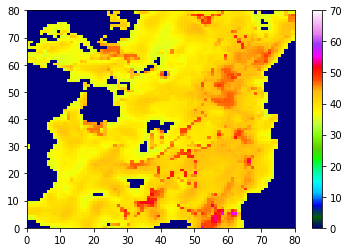

In [122]:
plt.pcolormesh(np.where(data["masks"][304630] > 0, data["REFL_COM_curr"][304630], 0), vmin=0, vmax=70, cmap="gist_ncar")
plt.colorbar()

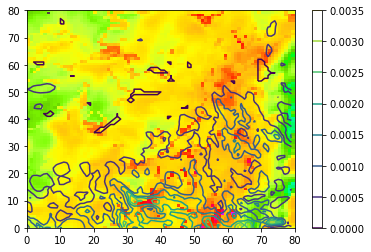

In [132]:
plt.pcolormesh(data["REFL_COM_curr"][304630], vmin=0, vmax=70, cmap="gist_ncar")
plt.contour(data["RVORT1_MAX_curr"][304630])

plt.colorbar()

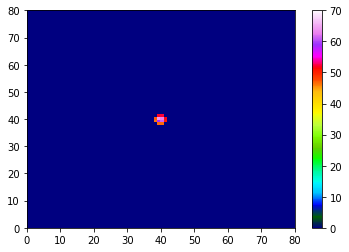

In [125]:
plt.pcolormesh(np.where(data["masks"][91958] > 0, data["REFL_COM_curr"][91958], 0), vmin=0, vmax=70, cmap="gist_ncar")
plt.colorbar()

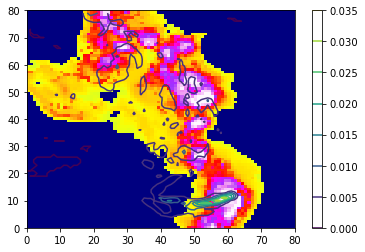

In [135]:
plt.pcolormesh(np.where(data["masks"][39180] > 0, data["REFL_COM_curr"][39180], 0), vmin=0, vmax=70, cmap="gist_ncar")
plt.contour(data["RVORT1_MAX_curr"][39180])
plt.colorbar()

In [59]:
mask_areas = data["masks"].sum(axis=-1).sum(axis=-1)


In [124]:
mask_areas.argsort()[:10]

<xarray.DataArray 'masks' (p: 10)>
array([ 91958, 213040,  41501,  74943, 264943, 150713, 272535, 168750,
       144888, 280889])
Coordinates:
  * p        (p) int64 0 1 2 3 4 5 6 7 8 9

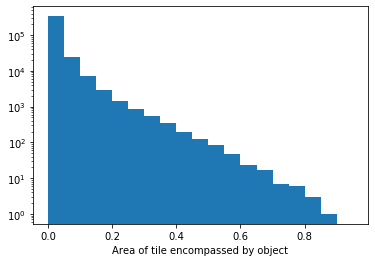

In [129]:
plt.hist(mask_areas / 80 ** 2, np.arange(0, 1, 0.05))
plt.xlabel("Area of tile encompassed by object")
plt.gca().set_yscale("log")

In [115]:
input_data = data["REFL_COM_curr"].expand_dims("channel", axis=-1)
output_data = (data["RVORT1_MAX_curr"] * data["masks"]).max(axis=-1).max(axis=-1)

In [133]:
output_data.argmax()

<xarray.DataArray ()>
array(39180)

In [30]:
split_point = int(0.7 * input_data.shape[0])
train_indices = np.arange(0, split_point)
test_indices = np.arange(split_point, input_data.shape[0])

In [33]:
np.percentile(output_data, 80)

0.005085554812103509

In [35]:
input_train = input_data.values[train_indices]
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [80]:
input_test = input_data.values[test_indices]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [36]:
threshold = 0.005
out_label = np.where(output_data.values > threshold, 1, 0)

In [79]:
cnn_model = BaseConvNet(min_filters=8, filter_growth_rate=1.5, output_type="sigmoid", learning_rate=0.001, epochs=15, batch_size=512,
                       data_format="channels_last", verbose=1)
cnn_model.fit(input_train_norm, out_label[train_indices])

Conv input shape (80, 80, 1)
4
None
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_input (InputLayer)      [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv_00 (Conv2D)             (None, 80, 80, 8)         208       
_________________________________________________________________
hidden_activation_00 (Activa (None, 80, 80, 8)         0         
_________________________________________________________________
pooling_00 (AveragePooling2D (None, 40, 40, 8)         0         
_________________________________________________________________
conv_01 (Conv2D)             (None, 40, 40, 12)        2412      
_________________________________________________________________
hidden_activation_01 (Activa (None, 40, 40, 12)        0         
_________________________________________________________________
pooling_01 (AveragePool

In [81]:
test_preds = cnn_model.predict(input_test_norm)
roc_auc_score(out_label[test_indices], test_preds.ravel())

0.8572846087562327

In [82]:
sub_model = Model(cnn_model.model.input, cnn_model.model.layers[-3].output)
node_out = sub_model.predict(input_train_norm, batch_size=2048)

In [83]:
node_roc_scores = np.zeros(node_out.shape[1])
for n in range(node_roc_scores.shape[0]):
    node_roc_scores[n] = roc_auc_score(out_label[train_indices], node_out[:, n])

In [137]:
np.sort(node_roc_scores)

array([0.21643338, 0.23250014, 0.25288839, 0.2557732 , 0.261506  ,
       0.26547552, 0.27108684, 0.27275664, 0.27388383, 0.27698186,
       0.2782724 , 0.28016342, 0.2802472 , 0.28150989, 0.28209678,
       0.28356341, 0.28585507, 0.28790674, 0.29023823, 0.29029295,
       0.29079569, 0.2914609 , 0.29476156, 0.29548236, 0.29617942,
       0.29747185, 0.29908863, 0.29925441, 0.30290373, 0.30698346,
       0.31043574, 0.31361491, 0.3137003 , 0.31415109, 0.3151721 ,
       0.31634056, 0.31702477, 0.32020036, 0.3228628 , 0.32367522,
       0.32604154, 0.32868744, 0.32919847, 0.32929681, 0.33206448,
       0.33403077, 0.33630395, 0.33673778, 0.33754329, 0.33803195,
       0.33875775, 0.33965852, 0.34085103, 0.34183406, 0.34399963,
       0.34449388, 0.34523811, 0.34591414, 0.34629117, 0.34933196,
       0.35275912, 0.35623445, 0.35847813, 0.35853251, 0.36158943,
       0.36245977, 0.36260619, 0.36310585, 0.36313461, 0.36631571,
       0.36674087, 0.36721321, 0.36756291, 0.36829228, 0.36892

In [84]:
node_ranks = np.argsort(node_roc_scores)[::-1]

In [55]:
node_ranks

array([1595, 2239, 1643, ..., 1763, 1744, 1611])

In [85]:
corr_matrix = np.corrcoef(node_out[:, node_ranks].T)

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


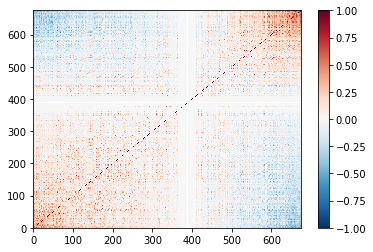

In [86]:
plt.pcolormesh(corr_matrix, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar()

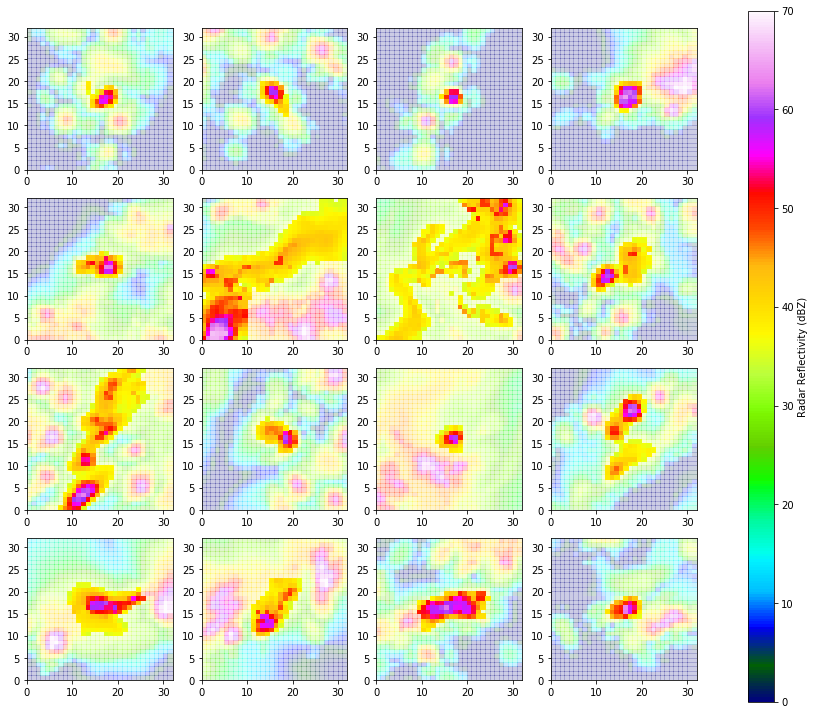

In [138]:
storm_ranks = node_out[node_ranks[0]].argsort()[::-1]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axef = axes.ravel()
for s, storm_num in enumerate(storm_ranks[:16]):
    axef[s].pcolormesh(input_train[storm_num, 24:56, 24:56, 0], vmin=0, vmax=70, cmap="gist_ncar", alpha=0.2)
    cont = axef[s].pcolormesh(np.ma.array(input_train[storm_num, 24:56, 24:56, 0], mask=data["masks"][storm_num, 24:56, 24:56]==0), vmin=0, vmax=70, cmap="gist_ncar")


cax = fig.add_axes([0.96, 0.1, 0.03, 0.8])
fig.colorbar(cont, cax=cax, label="Radar Reflectivity (dBZ)")

In [110]:
40 - 16

24

In [111]:
40 + 16

56